In [1]:
from dataset import ABIDE_I_Dataset
import matplotlib.pyplot as plt
dataset = ABIDE_I_Dataset()

In [2]:
test = dataset[999]

In [3]:
test['masked_img'].shape

torch.Size([192, 224, 224])

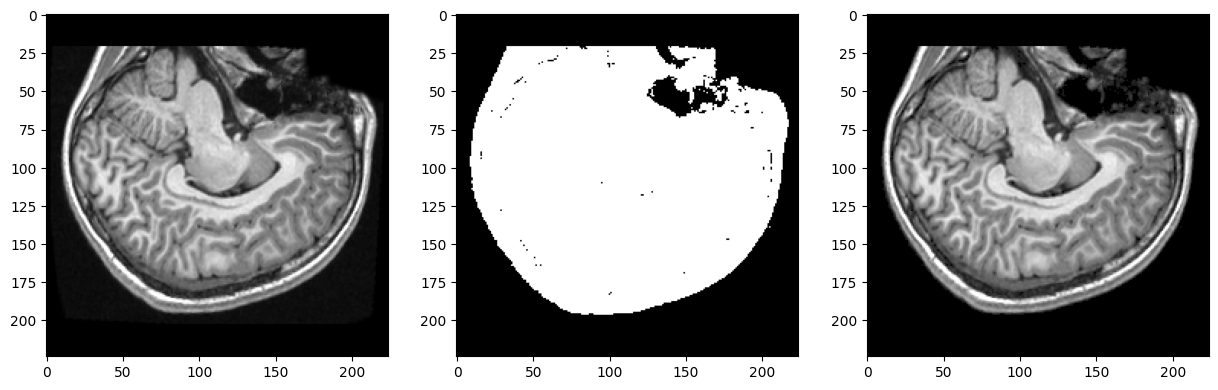

SUB_ID: 50501, LABEL: tensor([0., 1.])
<Control: 0, ASD: 1>


In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(test['img'][100], cmap='gray')
ax[1].imshow(test['mask'][100], cmap='gray')
ax[2].imshow(test['masked_img'][100], cmap='gray')
plt.show()
print(f"SUB_ID: {test['sub_id']}, LABEL: {test['label']}")
print("<Control: 0, ASD: 1>")

### Build the train pipeline

In [5]:
from beta_encoder import BetaEncoder
from classifier import R3DModel
import torch

In [6]:
beta_encoder = BetaEncoder(in_ch=1, out_ch=5, base_ch=8, final_act='none')
decoder = R3DModel(num_classes=2)

In [7]:
test['masked_img'][0].shape
torch.unsqueeze(test['masked_img'][0], dim=0).shape

torch.Size([1, 224, 224])

In [8]:
with torch.no_grad():
    beta = beta_encoder(test['masked_img'].unsqueeze(1))
    print(beta.shape)

torch.Size([192, 5, 224, 224])


In [9]:
beta = beta.squeeze(0).cpu() * test['mask'].unsqueeze(1)
beta.shape

torch.Size([192, 5, 224, 224])

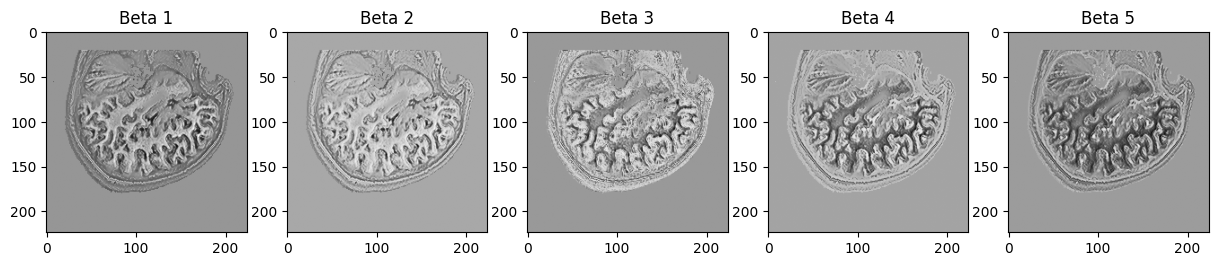

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(beta[50, i].numpy(), cmap='gray')
    ax[i].set_title(f"Beta {i+1}")

plt.show()


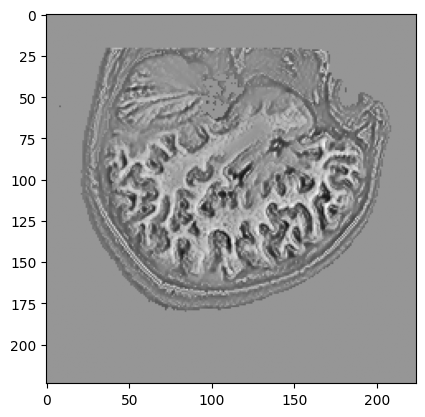

In [10]:
plt.imshow(beta[50, 0], cmap='gray')

In [11]:
res = decoder(beta.transpose(0, 1).unsqueeze(0))
res.shape

torch.Size([1, 2])

In [12]:
res

tensor([[-0.1015, -0.3144]], grad_fn=<AddmmBackward0>)

In [1]:
from beta_encoder import BetaEncoder
from classifier import R3DModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from dataset import ABIDE_I_Dataset
import gc
from tqdm import tqdm

In [ ]:
def encode_in_chunk

In [2]:
def train(epochs, optimizer, encoder, model, train_loader, val_loader, criterion, device):
    model.to(device)
    encoder.to(device)
    
    encoder.eval()
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 10)

        # Save data
        losses = []
        preds = []
        labels = []
        model.train()
        # Iterate over data
        for batch in tqdm(train_loader):
            # Move data to device
            # img shape: (B, 192, 224, 224)
            img = batch['masked_img'].to(device)
            mask = batch['mask'].to(device)
            label = batch['label'].to(device)

            # Get beta values
            # img shape reordered: (B*192, 1, 224, 224)
            img = img.permute(0, 2, 3, 1).reshape(-1, 1, 224, 224)
            mask = mask.permute(0, 2, 3, 1).reshape(-1, 1, 224, 224)
            beta = encoder(img)
            # beta shape: (B*192, 5, W, H)
            # mask shape: (B*192, 1, W, H)
            beta = beta.squeeze(0) * mask.unsqueeze(1)
            beta = beta.transpose(0, 1).unsqueeze(0)

            # classifier input shape: (B, 5, 192, W, H)
            beta = beta.reshape(-1, 5, 192, 224, 224)

            # Forward pass (Classifier)
            optimizer.zero_grad()
            pred = model(beta)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            # Store statistics
            losses.append(loss.item())
            preds.append(pred.argmax(dim=1).cpu())
            labels.append(label.cpu())

        # clean GPU memory
        del img, mask, label, beta, pred
        gc.collect()
        torch.cuda.empty_cache()

            
        # Print average loss
        avg_loss = sum(losses) / len(losses)
        print(f"Average Loss: {avg_loss:.4f}")
        # Print accuracy
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        acc = (preds == labels).sum().item() / len(labels)
        print(f"Accuracy: {acc:.4f}")

In [3]:
beta_encoder = BetaEncoder(in_ch=1, out_ch=5, base_ch=8, final_act='none')
decoder = R3DModel(num_classes=2)

In [4]:
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_batch_size = 1
val_batch_size = 1
dataset = ABIDE_I_Dataset()
train_val_split = 0.8

train_indices = int(len(dataset) * train_val_split)
train_dataset = Subset(dataset, range(train_indices))
val_dataset = Subset(dataset, range(train_indices, len(dataset)))

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

In [6]:
train(epochs=1, optimizer=optimizer, encoder=beta_encoder, model=decoder, train_loader=train_dataloader, val_loader=val_dataloader, criterion=criterion, device=device)

Epoch 1/1
----------


  0%|          | 0/881 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 588.00 MiB. GPU 0 has a total capacity of 11.63 GiB of which 332.69 MiB is free. Including non-PyTorch memory, this process has 10.65 GiB memory in use. Of the allocated memory 10.47 GiB is allocated by PyTorch, and 55.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)